In [1]:
import shelve
import re
import os
from predict_price_helpers import *

In [2]:
with shelve.open('./predict-price.shelve', flag='r') as slf:
    for k,v in slf.items():
        print(k)
        globals()[k] = v
        if re.match('def\d+:', k) is not None:
            print(v)
            exec(v)

RESULTS_DIR
def0:
do_save = lambda fn: not(os.path.isfile(fn))
cfg
num_columns
cat_columns
models
df


In [3]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns

In [4]:
# set figure defaults (needs to be in cell seperate from import sns)
plt.style.use([
    'default',
    f"{cfg['FILE_LOCATION']['app_dir']}/assets/movshon.mplstyle",
    f"{cfg['FILE_LOCATION']['app_dir']}/assets/context-notebook.mplstyle"
])

# Model: scaled price, but only young cars

Same as [model 2](#pred_model_2), but ignore cars older than 25y

## Prepare input

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model

model_name = 'linear regression log price young'

is_yng = df.age/365.25 < 25

X = df[is_yng].dropna(subset=['price','age']).age.values.reshape(-1,1)
y = np.log10(df[is_yng].dropna(subset=['price','age']).price.values.reshape(-1,1))
print(X.shape)
print(y.shape)

(8135, 1)
(8135, 1)


## Fit

In [6]:
# instantiate a dict in models at key with name of this model
models[model_name] = dict()

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

# create regression model object and store
reg = linear_model.LinearRegression()
models[model_name].update({'model':reg})

# fit
reg.fit(X_train,y_train)
models[model_name].update({'n':y.shape[0]})

# parameters
betas = [*reg.intercept_, *reg.coef_[0]]
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':reg.score(X,y)})
models[model_name].update({'test R^2':reg.score(X_test,y_test)})
cv_results = cross_val_score(reg, X_test, y_test, cv=5)
models[model_name].update({'cv R^2':cv_results})


(5694, 1)
(2441, 1)


In [7]:
depr_half_n_days = -(np.log10(2)/models[model_name]['betas'][1])
print('According to "{}"-model'.format(model_name))
print('Car depreciates to half its value every\n\t{:.0f} days ({:.1f} years).'.format(depr_half_n_days, depr_half_n_days/365.25))
for y in [0,2,4,6,8]:
    print('\ty(t={:+5.0f}) = {:.0f} euro'.format(y, 10**reg.predict([[y*365.25]])[0][0]))
print('\n\ty(t={:+5.1f}) = {:.0f} euro'.format(depr_half_n_days/365.25, 10**reg.predict([[depr_half_n_days]])[0][0]))
print('\ty(t=0) / 2 = {:.0f} euro'.format(10**models[model_name]['betas'][0]/2))

According to "linear regression log price young"-model
Car depreciates to half its value every
	1345 days (3.7 years).
	y(t=   +0) = 26095 euro
	y(t=   +2) = 17907 euro
	y(t=   +4) = 12288 euro
	y(t=   +6) = 8432 euro
	y(t=   +8) = 5786 euro

	y(t= +3.7) = 13048 euro
	y(t=0) / 2 = 13048 euro


/home/tom/bin/satdatsci/Saturday-Datascience/results/linear_regression_log_price_young.png


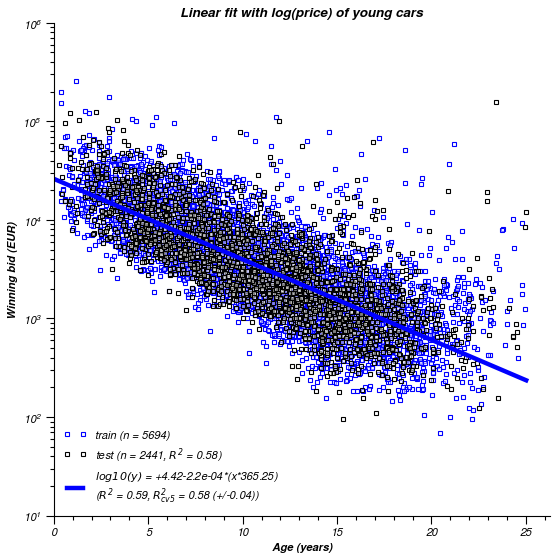

In [8]:
# Fit a line by using predict
prediction_X = np.array([0,int(np.ceil(X.max()/365.25))*365.25]).reshape(-1,1)
prediction_y = reg.predict(prediction_X)

# plot
plt.figure(figsize=[8,8])
hdl_trn = plt.plot(X_train/365.25, np.power(10,y_train), marker='s', markeredgecolor = (0, 0, 1, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4, 
                   label='train (n = {})'.format(y_train.shape[0]))
hdl_tst = plt.plot(X_test/365.25, np.power(10,y_test), marker='s', markeredgecolor = (0, 0, 0, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4, 
                   label='test (n = {}, $R^2$ = {:.2f})'.format(
                       y_test.shape[0],
                       models[model_name]['test R^2'],
                   ))
hdl_fit = plt.plot(prediction_X/365, np.power(10,prediction_y), color='blue', marker=None, linestyle='-', linewidth=4, 
                   label = '$log10(y)$ = {:+.2f}{:+.1e}*(x*365.25)\n($R^2$ = {:.2f}, $R^2_{{cv{:g}}}$ = {:.2f} (+/-{:.2f}))'.format(
                       *models[model_name]['betas'],
                       models[model_name]['R^2'],
                       models[model_name]['cv R^2'].shape[0],
                       np.mean(models[model_name]['cv R^2']),
                       np.std(models[model_name]['cv R^2']),
                   ))
plt.legend()
plt.xlabel('Age (years)', style='italic')
plt.ylabel('Winning bid (EUR)', style='italic')
plt.title('Linear fit with log(price) of young cars', style='italic')
plt.ylim(bottom = 10, top = 1000000)
plt.xlim(left = 0)
plt.yscale('log')

# Save
file_name = f"{RESULTS_DIR}/{model_name.replace(' ','_')}.png"
if True | do_save(file_name): # always save
    print(file_name)
    with plt.style.context(f"{cfg['FILE_LOCATION']['app_dir']}/assets/context-paper.mplstyle"):
        plt.savefig(file_name, bbox_inches='tight', transparent=False)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')

In [9]:
fn = './predict-price.shelve'
with shelve.open(fn, flag='w') as slf:
    slf['models'] = models 
    print(f'Shelve file [{fn}] contains models:')
    for m in slf['models'].keys():
        print(f'\t{m}')

Shelve file [./predict-price.shelve] contains models:
	linear regression no cv
	linear regression log price young
